In [8]:
import numpy as np
from typing import Callable, List, Tuple
from scipy import stats
import random
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Algorithm for generating money

Let RV $X$ be the remaining money in the pool ($X \in [0, 66]$), and RV
$K \sim \mathcal{U}(0, 1)$. Also we can safely assume that $X$ and $K$ are
independent.

Then the money of the $n$-th draw

$$ M_n = \max(0.01, K \frac{2X}{n}) $$

When $m > 0.01$, CDF of $M$

\begin{align*}
F_M(m) &= P\left[ \frac{2XK}{n} \le m \right] \\
&= P\left[ XK \le \frac{mn}{2} \right] \\
& = \int_{0}^{66}\int_{0}^{\frac{mn}{2x}}f_{XK}(x,k) dk dx \\
& = \int_{0}^{66}\int_{0}^{\frac{mn}{2x}}f_K(k)f_X(x) dk dx \\
& = \int_{0}^{66}\int_{0}^{\frac{mn}{2x}}k f_X(x) dk dx \\
& = \int_{0}^{66} \frac{f_X(x)m^2 n^2}{8x^2} dx \\
\end{align*}

Since $X = 66 - \sum_i M_i$

In [9]:
class RedBag:
    def __init__(self, n_bags: int, money: float):
        self.n_remain = self.n_bags = n_bags
        self.money_remain = self.money = money
        
    def get_money(self):
        """
        Get money from this red bag
        :return: how much money of a new red bag
        """
        # random.seed(1024)
        if self.n_remain ==  1:
            money = self.money_remain
            self.money_remain = 0
            self.n_remain = 0
        else:
            min_ = 0.01
            max_ = 2 * self.money_remain / self.n_remain
            money = random.random() * max_
            money = max(min_, money)
            self.n_remain -= 1
            self.money_remain -= money
        return money

In [10]:
def sim_trial(n_bags: int, money: float):
    rb = RedBag(n_bags, money)
    trials = [rb.get_money() for _ in range(n_bags)]
    return trials

In [11]:
n_trials = 10000
n_players = 10
money = 66.0
data = np.asarray([sim_trial(n_players, money) for i in range(n_trials)]).T
data.shape

(10, 10000)

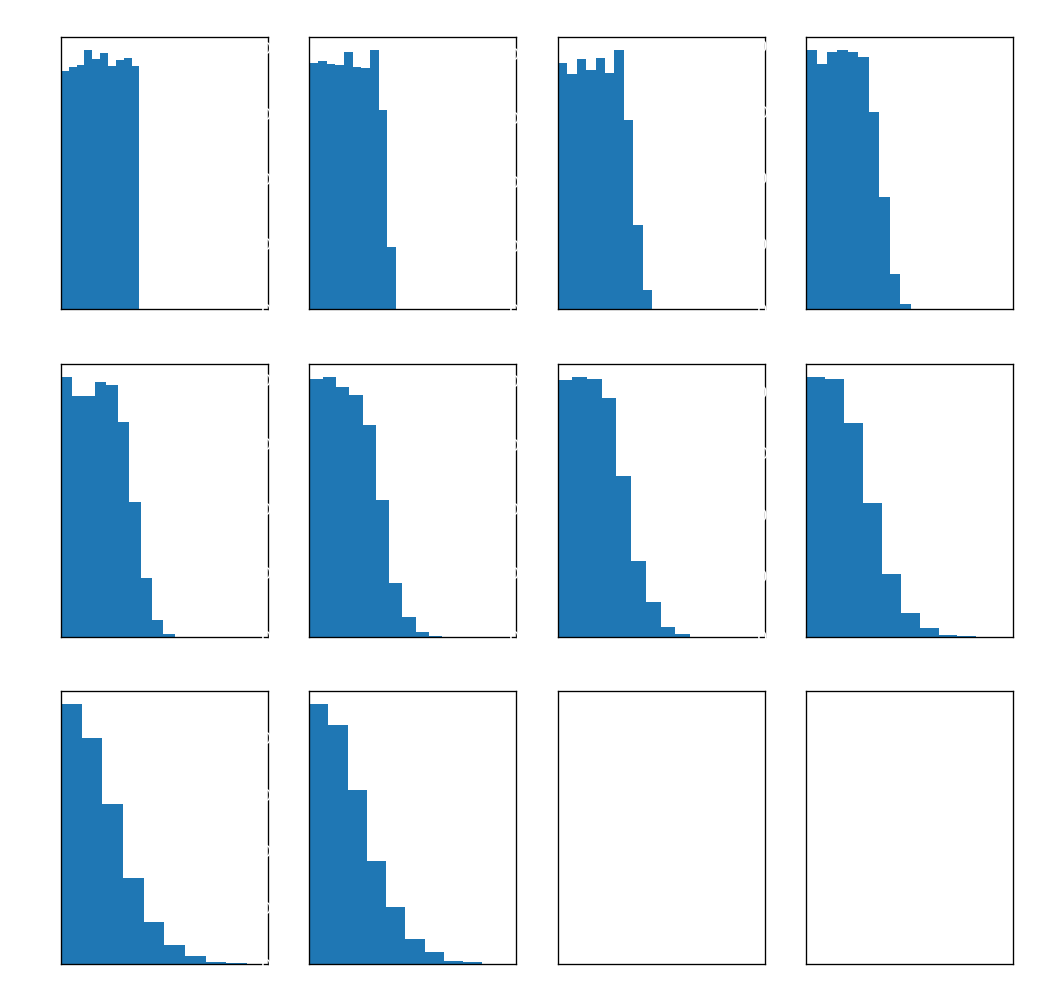

In [12]:
def plot_hist_for_players(data: np.ndarray):
    fig, axs = plt.subplots(3, 4)
    fig.set_size_inches(10.24, 10.24)
    axs = axs.flat
    xlim = np.max(data)
    histogram = [np.histogram(data[i,]) for i in range(10)]
    # hist = [h[0] for h in histogram]
    bins = [h[1] for h in histogram]
    for i in range(10):
        axs[i].hist(data[i,], bins=bins[i], density=True)
        axs[i].set_title('hist of {}-th'.format(i))
        axs[i].set_xlim([0, xlim])
    plt.show()

plot_hist_for_players(data)
data_true = np.loadtxt('trials.csv')
# plot_hist_for_players(data_true)

In [13]:
def get_dist(data: np.ndarray):
    histogram = [np.histogram(data[i,]) for i in range(10)]
    hist = np.asarray([h[0] for h in histogram])
    bins = np.asarray([h[1] for h in histogram])
    dist = hist / data.shape[1]
    return dist, bins

def get_bin_index(x: float, bins: np.ndarray):
    for i in range(bins.size - 1):
        if bins[i] <= x < bins[i+1]:
            return i
    

def get_cdf(i: int, dists: np.ndarray, bins: np.ndarray):
    dist: np.ndarray = dists[i, ]
    bins: np.ndarray = bins[i, ]
    def cdf(x: np.ndarray):
        bin_is = [get_bin_index(e, bins) for e in x]
        return dist[bin_is]
    return cdf

In [14]:
sim_dists, sim_bins = get_dist(data)
# display(sim_dists)
# display(sim_bins)
kstest_scores = [stats.kstest(data_true[i, ], get_cdf(i, sim_dists, sim_bins)) for i in range(data_true.shape[0])]
kstest_scores = np.asarray(kstest_scores)
display(kstest_scores[:, 0])

array([0.9017, 0.9724, 0.9902, 0.997 , 0.9899, 0.9967, 0.9997, 0.991 ,
       0.9893, 0.9961])